In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from sodapy import Socrata

from src.evaluate.metrics import evaluate, pai, pei, rri
from src.model.random_forest import RandomForestGridPred
from src.plotting import visualize_predictions
from src.prediction import GridPred

# Set up client
APP_TOKEN = "[TOKEN]"
client = Socrata("data.cityofnewyork.us", APP_TOKEN)


def get_date_lookback(lookback_days=14):
    "Retrieve a date from a number of lookback days"
    current_date = datetime.today()
    lookback_date = current_date - timedelta(days=lookback_days)

    return lookback_date.strftime("%Y-%m-%d")

In [2]:
# Workflow:
# first, we define a lookback period
# say 28 days?

BOROUGH = "MANHATTAN"
LOOKBACK_DAYS = 28

date = get_date_lookback(LOOKBACK_DAYS)


results = client.get("h9gi-nx95",
                     select="crash_date, borough, latitude, longitude",
                     where=f"crash_date >= '{date}' AND borough = '{BOROUGH}' AND latitude != 0 AND longitude != 0",
                     limit=5000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# we need to define a test\train period
# train on first 3 weeks, evaluate on last week


In [3]:
# get features
bus_stops = client.get("t4f2-8md7",
                    select="'BusStop' AS type,Longitude, Latitude",
                    where=f"boro_name = 'Manhattan'",
                    limit=1000)

bus_stops = pd.DataFrame(bus_stops)

In [4]:
ped_xing = client.get(
    "xc4v-ntf4",
    select="'PedXing' AS type, long AS Longitude, lat AS Latitude",
    limit=7000
)

ped_xing = pd.DataFrame(ped_xing)


In [5]:
feat_df = pd.concat([bus_stops,ped_xing])

In [6]:
results_df

# Parse datetime
results_df["crash_date"] = pd.to_datetime(results_df["crash_date"])

# Get the most recent date in the data
max_date = results_df["crash_date"].max()

# Compute week difference (integer weeks)
results_df["timevar"] = (
    (max_date - results_df["crash_date"]).dt.days // 7
) + 1

In [7]:

# define variable names
time_var = "timevar"
features_var = "type"

# spatial projections
# includes the coordinate reference system of the input crime data
# as well as a desired projection for all spatial objects
input_crime_crs = 4326
projected_crs = 3857

# size of the grid to use (in units based on projection)
grid_size = 400

# This initalizes the GridPred class with the specified data
gridpred = GridPred(
    input_crime_data=results_df,
    input_features_data=feat_df,
    features_names_variable=features_var,
    crime_time_variable=time_var,
    input_crs=input_crime_crs,
)

In [8]:
# This generates the input to the regression model
gridpred.prepare_data(
    grid_cell_size=grid_size,
    do_projection=True,
)

# Look at top 5 values in the predictor matrix
# is stored as a class object `X`
gridpred.X.head(100).round(2)

No projected CRS provided — defaulting to 3857


,crimes_1,crimes_2,PedXing,BusStop,x,y
62,0,0,41.49,501.70,-8238900.78,4968810.47
0,0,0,301.83,577.71,-8239226.14,4968845.87
1,1,1,245.26,315.66,-8239291.97,4969200.00
63,0,0,225.31,239.87,-8238904.00,4969198.00
2,0,0,51.36,303.06,-8239271.71,4969592.20
...,...,...,...,...,...,...
374,0,0,73.44,442.25,-8236904.96,4969599.02
436,0,0,218.52,393.40,-8236523.88,4969650.08
375,0,1,323.80,98.79,-8236904.00,4969998.00
437,0,0,159.58,48.28,-8236504.00,4969998.00


In [9]:
# very basic demo model workflow
# can replace with xgboost or whatever model
X = gridpred.X
y = gridpred.y

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(X, y)
y_pred = rf.predict(X)

In [10]:
# print feature importances
# TODO: in future, can be logged and plotted
importances = pd.Series(rf.get_feature_importances(), index=X.columns)
print(importances.sort_values(ascending=False))

BusStop     0.421234
PedXing     0.261848
y           0.148333
x           0.102625
crimes_2    0.035161
crimes_1    0.030799
dtype: float64


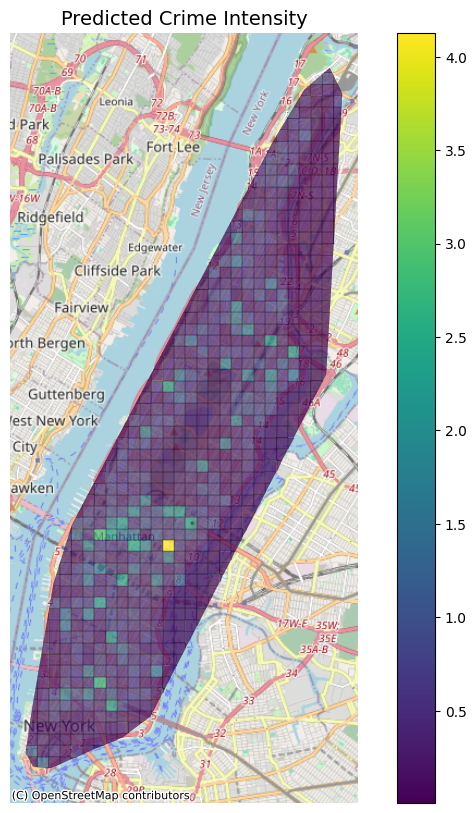

In [11]:
# plotting
region_grid = gridpred.region_grid
visualize_predictions(region_grid, y_pred)

In [12]:
# Pass a dict of pre-defined library metrics
METRICS = {'PAI': pai, 'PEI': pei, 'RRI': rri}

print(
    evaluate(
        y_true=gridpred.eval,
        y_pred=y_pred,
        metrics=METRICS,
        region_grid=region_grid,
        round_digits=2
    )
)


{'PAI': 1.46, 'PEI': 0.16, 'RRI': 1.64}
